In [53]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Loading Data

In [54]:
data_dir = "date-fruit-image-dataset-in-controlled-environment"
dataset_url = 'https://www.kaggle.com/wadhasnalhamdan/date-fruit-image-dataset-in-controlled-environment'
classes_name = ['Ajwa', 'Galaxy', 'Medjool', 'Meneifi', 'Nabtat Ali', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']

In [55]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [56]:
import opendatasets as od
od.download(dataset_url)

Skipping, found downloaded files in ".\date-fruit-image-dataset-in-controlled-environment" (use force=True to force download)


In [57]:
data_dir = pathlib.Path(data_dir)

**Counting images**

In [58]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1658


### Printing data folders

In [59]:
def directory_dataset(data_dir):
  folders = []
  for i in data_dir.iterdir():
    if i.is_dir():
      folders.append(i)
  return folders  
folders = directory_dataset(data_dir)
print(folders)

[WindowsPath('date-fruit-image-dataset-in-controlled-environment/Ajwa'), WindowsPath('date-fruit-image-dataset-in-controlled-environment/Galaxy'), WindowsPath('date-fruit-image-dataset-in-controlled-environment/Medjool'), WindowsPath('date-fruit-image-dataset-in-controlled-environment/Meneifi'), WindowsPath('date-fruit-image-dataset-in-controlled-environment/Nabtat Ali'), WindowsPath('date-fruit-image-dataset-in-controlled-environment/Rutab'), WindowsPath('date-fruit-image-dataset-in-controlled-environment/Shaishe'), WindowsPath('date-fruit-image-dataset-in-controlled-environment/Sokari'), WindowsPath('date-fruit-image-dataset-in-controlled-environment/Sugaey')]


### Load data using a Keras utility

Define some parameters

In [60]:
img_width = 180
img_height = 180
batch_size = 32
color = 3

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

**Training sets**

In [61]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1658 files belonging to 9 classes.
Using 1327 files for training.


**Validation sets**

In [62]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1658 files belonging to 9 classes.
Using 331 files for validation.


You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

In [63]:
class_names = train_ds.class_names
print(class_names)

['Ajwa', 'Galaxy', 'Medjool', 'Meneifi', 'Nabtat Ali', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']


### Visualize the data

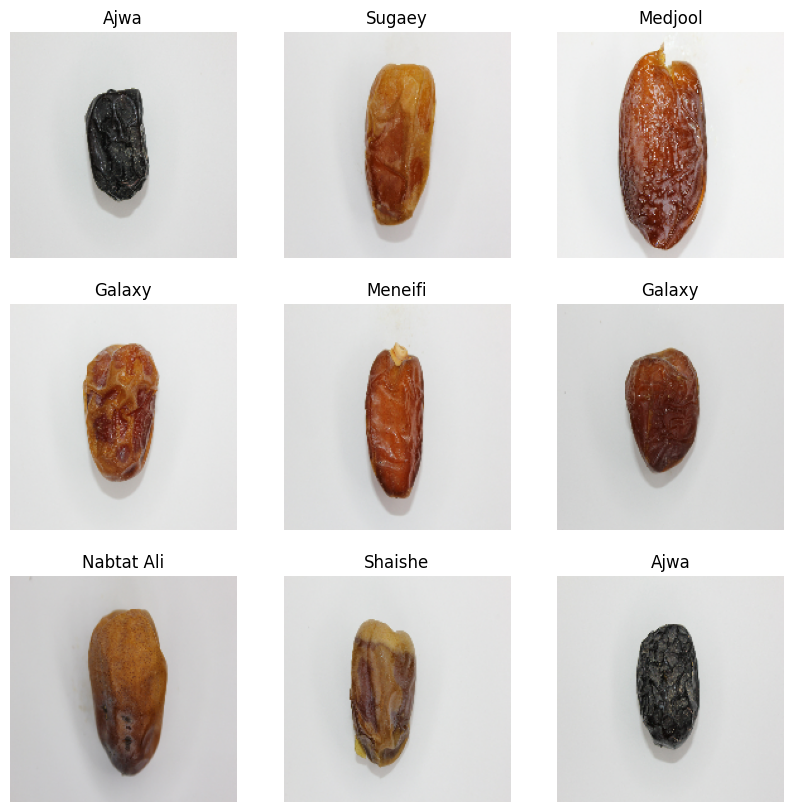

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [65]:
def number_of_images_in_each_folder(folders):
  for i in folders:
    str_ = "{}: {}".format(i, len(list(pathlib.Path(i).glob("*.*"))))
    print(str_)
    
number_of_images_in_each_folder(folders)

date-fruit-image-dataset-in-controlled-environment\Ajwa: 175
date-fruit-image-dataset-in-controlled-environment\Galaxy: 190
date-fruit-image-dataset-in-controlled-environment\Medjool: 135
date-fruit-image-dataset-in-controlled-environment\Meneifi: 232
date-fruit-image-dataset-in-controlled-environment\Nabtat Ali: 177
date-fruit-image-dataset-in-controlled-environment\Rutab: 146
date-fruit-image-dataset-in-controlled-environment\Shaishe: 171
date-fruit-image-dataset-in-controlled-environment\Sokari: 264
date-fruit-image-dataset-in-controlled-environment\Sugaey: 168


date-fruit-image-dataset-in-controlled-environment\Ajwa\Ajwa Date (1).JPG


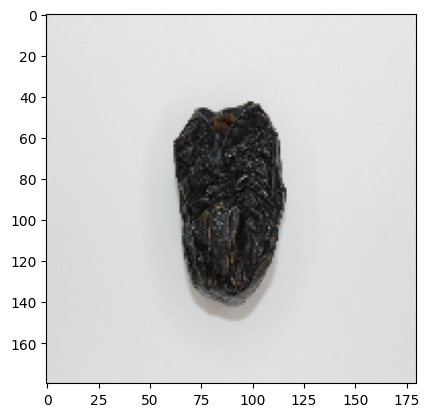

date-fruit-image-dataset-in-controlled-environment\Galaxy\Galaxy Date (1).JPG


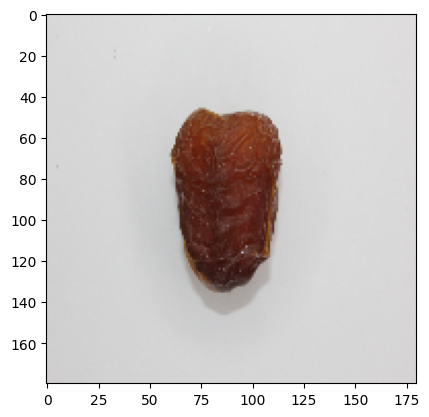

date-fruit-image-dataset-in-controlled-environment\Medjool\Medjool Date (1).JPG


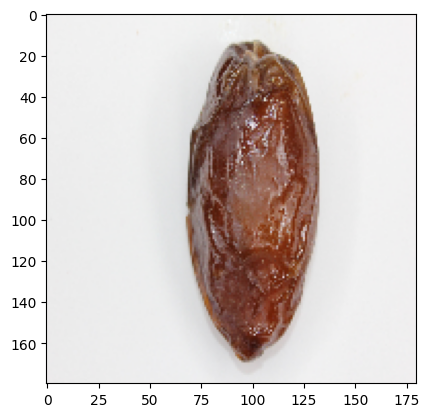

date-fruit-image-dataset-in-controlled-environment\Meneifi\Meneifi Date (1).JPG


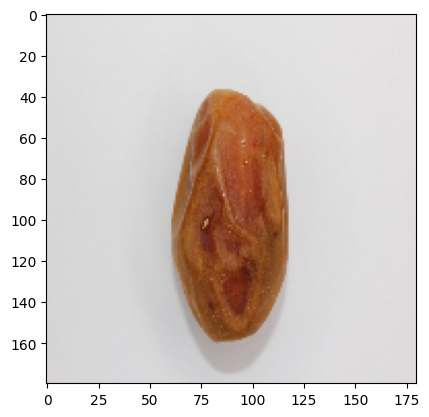

date-fruit-image-dataset-in-controlled-environment\Nabtat Ali\Nabtat Ali Date (1).JPG


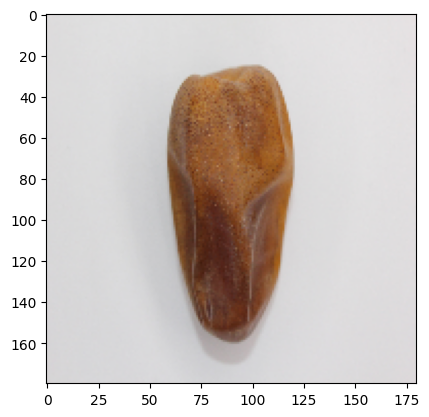

date-fruit-image-dataset-in-controlled-environment\Rutab\Rutab Date (1).JPG


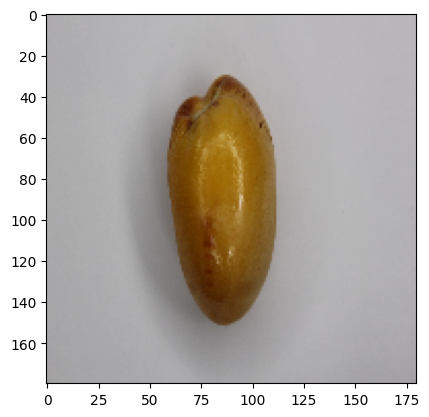

date-fruit-image-dataset-in-controlled-environment\Shaishe\Shaishe Date (1).JPG


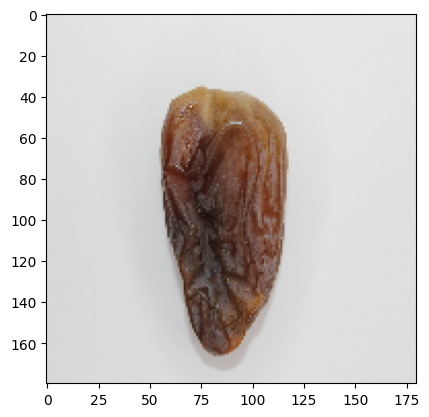

date-fruit-image-dataset-in-controlled-environment\Sokari\Sokari Date (1).JPG


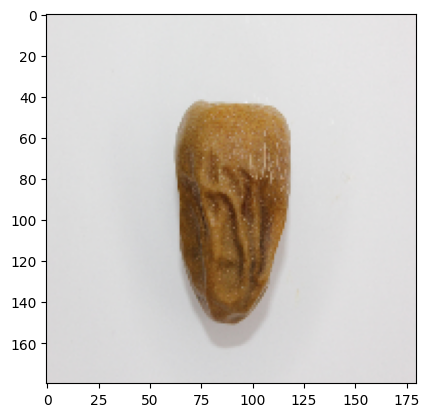

date-fruit-image-dataset-in-controlled-environment\Sugaey\Sugaey Date (1).JPG


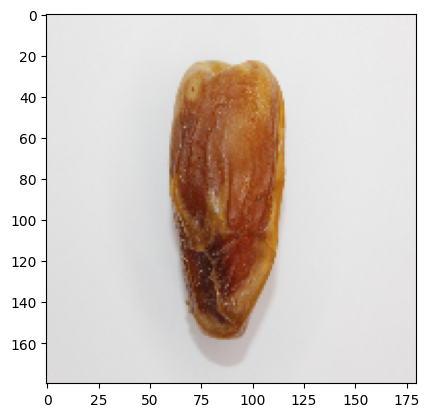

In [66]:
import cv2
import os

def show_single_image_in_each_directory(folders):
  for i in folders:
    images = list(pathlib.Path(i).glob("*.*"))
    print(images[0])
    img = cv2.imread(os.path.join(images[0]))
    img = cv2.resize(img, (img_width, img_height))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    
show_single_image_in_each_directory(folders) 

You will pass these datasets to the Keras `Model.fit` method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:**

In [67]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,),` these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.

### Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.


- `Dataset.prefetch` overlaps data preprocessing and model execution while training.
Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide.

In [68]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [69]:
normalization_layer = layers.Rescaling(1./255)

In [70]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.024314014 0.9196078


### A basic Keras model

**Create the model**

The Keras `Sequential` model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a `ReLU` activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [71]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

The `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to `Model.compile`.

In [72]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [73]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [74]:
epochs=25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
42/42 [==============================] - 33s 764ms/step - loss: 2.1318 - accuracy: 0.2163 - val_loss: 1.7632 - val_accuracy: 0.3142
Epoch 2/25
42/42 [==============================] - 26s 614ms/step - loss: 1.3708 - accuracy: 0.5079 - val_loss: 0.9606 - val_accuracy: 0.6344
Epoch 3/25
42/42 [==============================] - 26s 631ms/step - loss: 0.7919 - accuracy: 0.7423 - val_loss: 0.7336 - val_accuracy: 0.7734
Epoch 4/25
42/42 [==============================] - 30s 715ms/step - loss: 0.5037 - accuracy: 0.8282 - val_loss: 0.6443 - val_accuracy: 0.7946
Epoch 5/25
42/42 [==============================] - 28s 657ms/step - loss: 0.4564 - accuracy: 0.8531 - val_loss: 0.5263 - val_accuracy: 0.8429
Epoch 6/25
42/42 [==============================] - 26s 612ms/step - loss: 0.4040 - accuracy: 0.8749 - val_loss: 0.5355 - val_accuracy: 0.8278
Epoch 7/25
42/42 [==============================] - 25s 600ms/step - loss: 0.3589 - accuracy: 0.8832 - val_loss: 0.4664 - val_accuracy: 0.8520

### Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

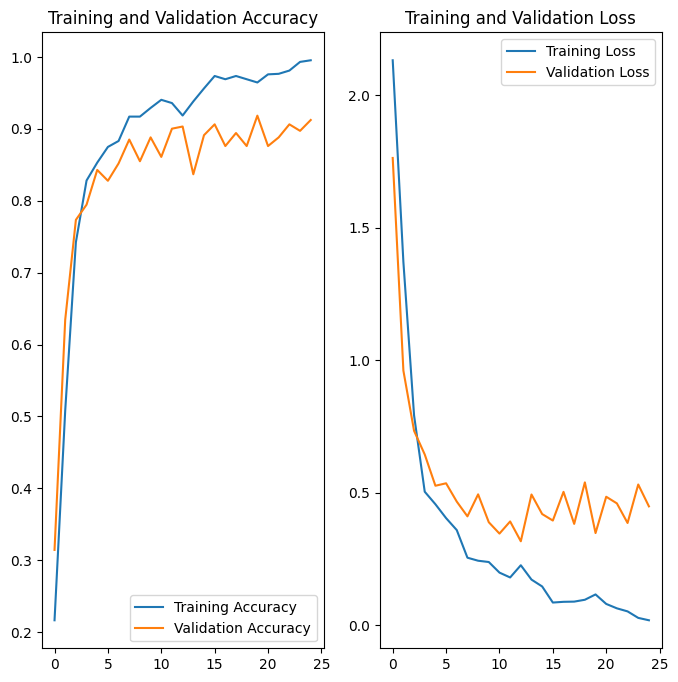

In [75]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Predict on new data
Use your model to classify an image that wasn't included in the training or validation sets.

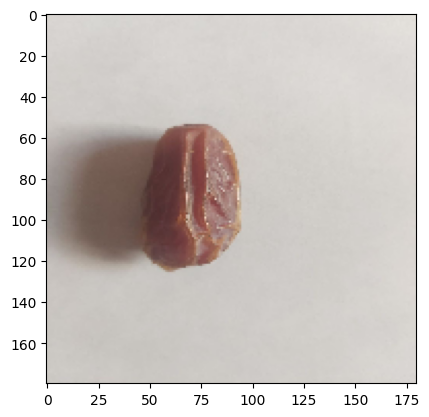

In [99]:
from tensorflow.keras.preprocessing import image

img_path = "C:\\Users\\hp\\Downloads\\test_date_6.jpg"
img = image.load_img(img_path, target_size=(180, 180))
plt.imshow(img)
plt.show()

In [100]:
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
#img_preprocessed = preprocess_input(img_batch)

In [101]:
#test_img_path = tf.keras.utils.get_file('C:\\Users\\hp\\Downloads\\test_date_1.jpg')

#img = tf.keras.utils.load_img(
#    test_img_path, target_size=(img_height, img_width)
#)
#img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 29ms/step
This image most likely belongs to Shaishe with a 99.94 percent confidence.


### Use TensorFlow Lite

TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

### Convert the Keras Sequential model to a TensorFlow Lite model

To use the trained model with on-device applications, first convert it to a smaller and more efficient model format called a TensorFlow Lite model.

IHere we take the trained Keras `Sequential model` and use `tf.lite.TFLiteConverter.from_keras_model` to generate a TensorFlow Lite model:

In [102]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\hp\AppData\Local\Temp\tmppy9e09jt\assets


INFO:tensorflow:Assets written to: C:\Users\hp\AppData\Local\Temp\tmppy9e09jt\assets


In [104]:
# Save the model.
with open('modelC.tflite', 'wb') as f:
  f.write(tflite_model)

In [105]:
model.save('my_model')

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets
